In [9]:
import cv2
import matplotlib.pyplot as plt
from itertools import chain, combinations
import numpy as np
from PIL import Image

import torch
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
from tqdm import tqdm
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import itertools
import matplotlib.patches as patches
from torchvision import transforms
from PIL import Image
from itertools import combinations 
import math


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
image_name = "1f8f08ea-b5b3-4f68-94d4-3cc071b7dce8.png"
root_path = "/content/drive/MyDrive/Colab Notebooks/"
image_path = root_path + image_name
shap_image_path = root_path + 'Shap_image/'

In [4]:
def mask_generate(I,k,grey_area):
    """
    assign quadents of the image to black (masking certain region of the image to black)
    input: 
      I: image 
      k: quadents index 
      grey area: quadents indexs that to be black out
    output: 
      I_copy: is the blacked out masked image
    """
    I_copy = I.copy()
    shape1=I.shape[0]//(2**k)
    shape2=I.shape[1]//(2**k)
    for i in range(len(grey_area)):
        row=grey_area[i]//(2**k)
        col=grey_area[i]-row*(2**k)
        if col==0:
            col=2**k
        col-=1
        startr=row*shape1;endr=(row+1)*shape1
        startc=col*shape2;endc=(col+1)*shape2
        I_copy[startr:endr,startc:endc,:]=0
    return I_copy

In [19]:
def generate_combinations(num_parts):
    '''
    generate all combinations of different players (total of num_parts players)
    input: 
      num_parts: total number of players
    output: 
      combination_list: list of all different combinations
    '''
    list_parts = list(range(num_parts))
    combination_list = []
    for i in range(num_parts+1):
        combination_list_curr = list(combinations(list_parts,i))
        combination_list = combination_list + combination_list_curr
    return combination_list

def generate_masked_images(I,k, num_parts, save_dir, isSmall):
    '''
    generate all black out images with all different combinations
    input: 
      I: image 
      k: player index 
      num_parts: total number of players
      save_dir: the directory to save the black out masked image 
      isSmall: if output a small size image (small 256*256*3, if not small 1200*1600*3)
    '''
    grey_area_list_tuple = generate_combinations(num_parts)
    grey_area_list = []
    for i in range(len(grey_area_list_tuple)):
        grey_area_list.append(list(grey_area_list_tuple[i]))
    # print(grey_area_list)
    for i in range(len(grey_area_list)):
        print(list(grey_area_list[i]))
        I_m = mask_generate(I, k, grey_area_list[i])
        # plt.imshow(I_m)
        # print(I_m.shape)
        if isSmall == False: 
            if len(grey_area_list[i]) > 0:
                for j in range(len(grey_area_list[i])):
                    grey_area_list[i][j] = grey_area_list[i][j] + 1
                myString = ''.join(map(str,grey_area_list[i]))
                # print("/output_"+myString+".png")
                I_m.save(save_dir+"/output_"+myString+".png")
            else: 
                I_m.save(save_dir+"/output_.png")
        else: 
            newsize = (256, 256)
            I_m_copy = I_m.copy()
            plt.imshow(I_m_copy)
            I_m_r = cv2.resize(I_m_copy,newsize)
            I_m_r_image = Image.fromarray(I_m_r, "RGB")
            if len(grey_area_list[i]) > 0:
                for j in range(len(grey_area_list[i])):
                    grey_area_list[i][j] = grey_area_list[i][j] + 1
                myString = ''.join(map(str,grey_area_list[i]))
                # print("/output_"+myString+".png")
                I_m_r_image.save(save_dir+"/output_"+myString+".png")
            else: 
                I_m_r_image.save(save_dir+"/output_.png")
    return grey_area_list

In [6]:
def excluded_list_generation(num_of_players):
  """Generate list of combination of players based on num_of_player
  :param num_of_players: integer representing number of player
  :return: combination
  """
  numbers = list(range(num_of_players))
  combinations = []
  for r in range(len(numbers)+1):
      for combination in itertools.combinations(numbers, r):
          combinations.append(list(combination))
  return combinations

def get_model_result(image, model):
    """Return binary classifier result of a model
    :param image: image to be analyzed
    :param model: pytorch classifier model
    :return: probability of being class 1
    """
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    transform = transforms.Compose(
        [transforms.ToTensor(), 
        transforms.Normalize(mean=mean, std=std),
        ]
    )
    prep_img = transform(image).to(device)
    prep_img = torch.unsqueeze(torch.tensor(prep_img).float(), 0)
    prob_scores = model(prep_img).cpu().detach().numpy()[0]
    p = prob_scores[1]
    return p

# Code for Shapley value calculation
def exclude_k_matrics_calculation(k,directory, M, model):
    """Calculate prediction score for patched images excluding player k

    :param k: integer representing player k
    :param directory: directory contains intermediate images
    :param M: integer represents the number of player
    :param model: pytorch model
    :return:
    list of all player combinations that excludes player k,
    corresponding team index of each of the player combinations that excludes player k
    list of players
    corresponding prediction probability of containing sick cell
    list of all player combinations that includes player k,
    corresponding team index of each of the player combinations that includes player k
    """
    exclude_player2_list = []
    exclude_player2_team_index_list = []
    player_list = []
    probList = []
    contains_player2_list = []
    contains_player2_team_index_list = []
    team_index = 0 
    all_players = list(range(1,M+1))

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    transform = transforms.Compose(
        [transforms.ToTensor(), 
        transforms.Normalize(mean=mean, std=std),
        ]
    )
    
    for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            # checking if it is a file
            if os.path.isfile(f) and f[-4:] == '.png' and "output" in filename:
                ext = filename[7:-4] # if large 16 if small 7
                # print(ext)
                players_excluded = list(ext)
                players_excluded = [int(i) for i in players_excluded]
                players = all_players.copy()
                for excludedPalyerId in players_excluded: 
                    players.remove(excludedPalyerId)
                if k in players:
                    contains_player2_list.append(players)
                    contains_player2_team_index_list.append(team_index)
                else: 

                    exclude_player2_list.append(players)
                    exclude_player2_team_index_list.append(team_index)
                player_list.append(players)
                image = Image.open(directory+"/"+filename).convert('RGB')
                image_t = image
                print(image_t)
                prep_img = transform(image_t).to(device)
                
                prep_img = torch.unsqueeze(torch.tensor(prep_img).float(), 0)
                prob_scores = model(prep_img).cpu().detach().numpy()[0]
                p = prob_scores[1]
                probList.append(p)
                team_index += 1
    return exclude_player2_list, exclude_player2_team_index_list, player_list, probList, contains_player2_list, contains_player2_team_index_list


def shap_k_calulation(k, exclude_playerk_list, exclude_playerk_team_index_list, player_list, probList, contains_playerk_list, contains_playerk_team_index_list, M):
    """ Calculate the shapley value for player k

    :param k: player k
    :param exclude_playerk_list: list of all player combinations that excludes player k
    :param exclude_playerk_team_index_list: corresponding team index of each of the player combinations that excludes player k
    :param player_list: list of players
    :param probList: corresponding prediction probability of containing sick cell
    :param contains_playerk_list: list of all player combinations that includes player k
    :param contains_playerk_team_index_list: corresponding team index of each of the player combinations that includes player k
    :param M: num of players
    :return: shapley value
    """
    shap_k = 0
    for i, teams_withk in enumerate(contains_playerk_list):
        
        teams_withoutk = teams_withk.copy()
        teams_withoutk.remove(k)
        subset_size = len(teams_withoutk)
        prob_excluded = probList[exclude_playerk_team_index_list[exclude_playerk_list.index(teams_withoutk)]]
        # print("---")
        # print(teams_withoutk)
        # print(prob_excluded)
        # print(exclude_playerk_team_index_list[exclude_playerk_list.index(teams_withoutk)])
        prob_with = probList[contains_playerk_team_index_list[i]]
        # print(teams_withk)
        # print(prob_with)
        shap_k = shap_k + (math.factorial(subset_size)*math.factorial(M-subset_size-1))*(prob_with-prob_excluded)/math.factorial(M)
        # print(contains_playerk_team_index_list[i])
    print("the shap value of {} is: {} ".format(k,shap_k))
    return shap_k


def shap_main(k_list, directory, M, model):
    """Run Shapley Calculation for model by assessing each player in k_list with images we obtained from directory

    :param k_list: a list contains players (integers)
    :param directory: directory contains images
    :param M: int represents number of player
    :param model: model for Shapley value evaluations
    :return: a list in the format of [(player_id, shapley_score), ...]
    """
    shap_value_list = []
    for k in k_list:     
        print("====================== looking at k=" + str(k))
        exclude_playerk_list, exclude_playerk_team_index_list, player_list, probList, contains_playerk_list, contains_playerk_team_index_list = exclude_k_matrics_calculation(k,directory, M, model)
        # print(probList)
        shap_k = shap_k_calulation(k, exclude_playerk_list, exclude_playerk_team_index_list, player_list, probList, contains_playerk_list, contains_playerk_team_index_list, M)
        shap_value_list.append([k,shap_k])
    return shap_value_list

In [22]:
# Load the classifier
device = "cuda"
filename = root_path + 'model_git.pt'
model_git = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", pretrained=False)
num_ftrs = model_git.fc.in_features
model_git.fc = nn.Linear(num_ftrs, 2)
model_git.load_state_dict(torch.load(filename, map_location=device))
model_git = model_git.to(device)
model_git.eval()
torch.cuda.empty_cache()
model_git = nn.Sequential(
    model_git,
    nn.Softmax(dim=1),
)
print(model_git)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [13]:
image = cv2.imread(image_path) # load prediction model
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

[]
[0]
[1]
[2]
[3]
[0, 1]
[0, 2]
[0, 3]
[1, 2]
[1, 3]
[2, 3]
[0, 1, 2]
[0, 1, 3]
[0, 2, 3]
[1, 2, 3]
[0, 1, 2, 3]


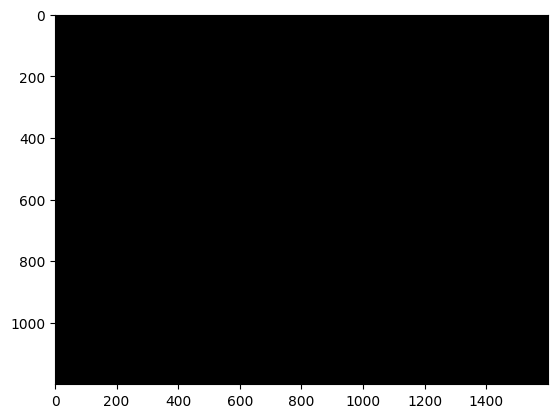

In [21]:
k_list = generate_masked_images(image,1, 4, shap_image_path, True) # generate the masked images 

In [25]:
shap_value_list = shap_main([1,2,3,4], shap_image_path, 4, model_git) # run shapley calculation

====================== looking at k=1
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EFE8D6110>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8181A20>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF81815D0>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF81822C0>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8181210>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8180F10>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8181A20>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF81813C0>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8181210>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8181A20>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8183F10>


<ipython-input-6-d83fb28edad4>:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prep_img = torch.unsqueeze(torch.tensor(prep_img).float(), 0)


<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF81813C0>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8183CD0>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8181150>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8181360>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8181A20>
the shap value of 1 is: 0.12230874318629503 
====================== looking at k=2
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF81831C0>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8181A20>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8180610>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8181A20>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8180610>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF81831C0>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF81810F0>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF8181150>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9EF81825F0>
<PIL.Image.Image imag

In [26]:
print(shap_value_list)

[[1, 0.12230874318629503], [2, 0.012184137323250384], [3, 0.713474699606498], [4, 0.14027499252309403]]
